In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

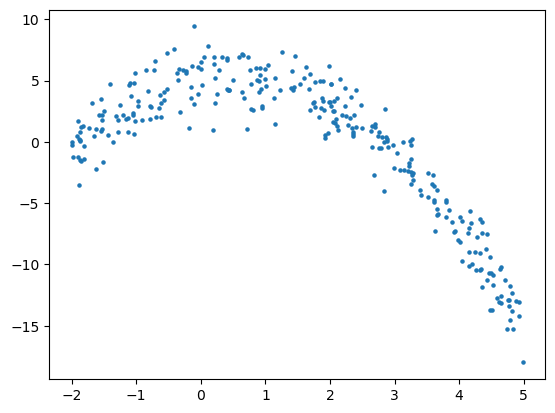

In [2]:
def f(x):
    mu, sigma = 0, 1.5
    return -x**2 + x + 5 + np.random.normal(mu, sigma, 1)

num_points = 300
np.random.seed(1)

X = np.random.uniform(-2, 5, num_points)
y = np.array([f(i) for i in X])
plt.scatter(X, y, s=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

In [3]:
class RegressionTree:
    def __init__(self):
        self.root = None

    # sum of squared residuals
    @staticmethod
    def SSR(r, y):
        return np.sum((r-y)**2)
    def min_threshold_val(self, X, y):
        # X, y = dataset[:, :-1], dataset[:, -1]
        
        min_SSR = float("inf")
        threshold_val = 0
        
        for i in range(len(X)-1):
            # threshold is the point we split upon
            threshold = X[i:i+2].mean()

            low = np.take(y, np.where(X < threshold)[0])
            high = np.take(y, np.where(X > threshold)[0])

            guess_low = low.mean()
            guess_high = high.mean()

            SSR_val = RegressionTree.SSR(low, guess_low) + RegressionTree.SSR(high, guess_high)
            if SSR_val < min_SSR:
                min_SSR = SSR_val
                threshold_val = threshold
        return threshold_val, min_SSR
        
    def get_split(self, dataset):
        b_index, b_threshold, b_groups, b_SSR = float("inf"), float("inf"), None, float("inf")

        for index in range(len(dataset[0])-1):
            X = dataset[:, index]
            y = dataset[:, -1]
            cur_threshold, curr_SSR = self.min_threshold_val(X, y)
            
            if cur_threshold < b_threshold:
                b_index = index
                b_threshold = cur_threshold
                b_groups = dataset[np.where(X < cur_threshold)], dataset[np.where(X > cur_threshold)]
                b_SSR = curr_SSR
        return_dict = {"index": b_index, "threshold": b_threshold, "groups": b_groups, "SSR": b_SSR}
        return return_dict

    def to_terminal(self, group):
        return np.mean(group[:, -1])
        
    def split(self, node, max_depth, min_size, depth):
        left, right = node["groups"]
        # print(f"{left = }\n\n{right=}")
        if not left.all() or not right.all():
            node["left"] = node["right"] = self.to_terminal(left if not left else right)
            return None
            
        if depth >= max_depth:
            node["left"] = self.to_terminal(left)
            node["right"] = self.to_terminal(right)
            return None
            
        if len(left) <= min_size:
            node["left"] = self.to_terminal(left)
        else:
            node["left"] = self.get_split(left)
            self.split(node["left"], max_depth, min_size, depth+1)

        if len(right) <= min_size:
            node["right"] = self.to_terminal(right)
        else:
            node["right"] = self.get_split(right)
            self.split(node["right"], max_depth, min_size, depth+1)

    def build_tree(self, dataset, min_size, max_depth):
        self.root = self.get_split(dataset)
        self.split(self.root, max_depth, min_size, 1)

    def predict(self, dataset):
        return [self.predict_(row, self.root) for row in dataset]
        
    def predict_(self, row, node):
        if row[node["index"]] < node["threshold"]:
            if isinstance(node["left"], dict):
                return self.predict_(row, node["left"])
            else:
                return node["left"]
        else:
            if isinstance(node["right"], dict):
                return self.predict_(row, node["right"])
            else:
                return node["right"]

In [4]:
dataset = np.hstack((X_train.reshape(-1, 1), y_train))

In [5]:
# implementing out model
min_size = 10
max_depth = 5

rt = RegressionTree()
rt.build_tree(dataset, min_size, max_depth)

In [6]:
inp_dataset = np.hstack((X_test.reshape(-1, 1), y_test))
y_pred = rt.predict(inp_dataset)

In [7]:
r2_score(y_test, y_pred)

0.9190967310600348

In [8]:
# implementing sklearn's DecisionTreeRegressor model
from sklearn.tree import DecisionTreeRegressor

X_train_reshaped, X_test_reshaped = np.reshape(X_train, (-1, 1)), np.reshape(X_test, (-1, 1))
dtr = DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=1)
dtr.fit(X_train_reshaped, y_train)

DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=1)

In [9]:
dtr.score(X_test_reshaped, y_test)

0.9021430580122611

In [10]:
# finding the best parameter values for DecisionTreeRegressor()

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
params = {
    "max_depth": list(range(1, 20)),
    "min_samples_split": list(range(2, 20))
}
grid_search_cv = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=1),
    param_grid=params,
    cv=3,
    error_score='raise'
)
grid_search_cv.fit(X_train_reshaped, y_train)

GridSearchCV(cv=3, error_score='raise',
             estimator=DecisionTreeRegressor(random_state=1),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18,
                                               19]})

In [13]:
grid_search_cv.best_estimator_

DecisionTreeRegressor(max_depth=5, min_samples_split=14, random_state=1)

In [14]:
grid_search_cv.score(X_test_reshaped, y_test)

0.9075627854211412

Applying PolynomialFeatures and then training LinearRegression model on the data

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [16]:
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train_reshaped)
X_test_poly = poly.transform(X_test_reshaped)

In [17]:
lr = LinearRegression()
lr.fit(X_train_poly, y_train.ravel())

LinearRegression()

[]

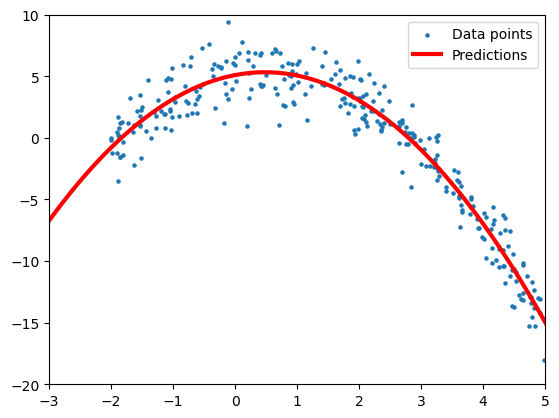

In [20]:
X_new = np.linspace(-3, 6, 100).reshape(-1, 1)
X_new_poly = poly.transform(X_new)
y_pred = lr.predict(X_new_poly)

plt.scatter(X, y, s=5, label="Data points")
plt.plot(X_new, y_pred, 'r-', lw=3, label="Predictions")
plt.xlim(-3, 5)
plt.ylim(-20, 10)
plt.legend()
plt.plot()

In [21]:
r2_score(y_test, lr.predict(X_test_poly))

0.922867844043734